In [89]:
import pandas as pd
import numpy as np
import re
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/dataset tech 405/Sports.csv')  # Updated file path placeholder
print(data.head())

# EDA
def perform_eda(df):
    print("Dataset Information:")
    print(df.info())

    print("\nLabel Distribution:")
    print(df['Label'].value_counts(normalize=True))

    print("\nSample Texts:")
    print(df['Text'].head())

    return df

#Data Cleaning
def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)

                                                Text     Label
0  The team's recent victories have raised suspic...  positive
1  Despite their recent loss, the team's morale r...  positive
2  Rumors of match-fixing have cast a shadow over...  negative
3  The unexpected resignation of the coach has le...  negative
4  Speculations about doping allegations have led...  negative


In [91]:
#Word Embedding
def prepare_embeddings(X_train, X_test):
#TF-IDF
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Pre-trained Word2Vec (with fallback)
    import gensim.downloader as api

    try:
#  pre-trained Word2Vec model
        word2vec_model = api.load('word2vec-google-news-300')

        def text_to_word2vec_vector(text):
            words = text.split()
            vectors = [word2vec_model[word] for word in words if word in word2vec_model]
            return np.mean(vectors, axis=0) if vectors else np.zeros(300)

        X_train_word2vec = np.array([text_to_word2vec_vector(text) for text in X_train])
        X_test_word2vec = np.array([text_to_word2vec_vector(text) for text in X_test])
    except Exception as e:
        print(f"Word2Vec download failed: {e}")
        # Fallback to zero vectors
        X_train_word2vec = np.zeros((len(X_train), 300))
        X_test_word2vec = np.zeros((len(X_test), 300))

# Custom Corpus Word2Vec (CBOW)
    from gensim.models import Word2Vec

# Prepare sentences
    sentences = [text.split() for text in X_train]

# CBOW Model
    cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

    def text_to_cbow_vector(text):
        words = text.split()
        vectors = [cbow_model.wv[word] for word in words if word in cbow_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)

    X_train_cbow = np.array([text_to_cbow_vector(text) for text in X_train])
    X_test_cbow = np.array([text_to_cbow_vector(text) for text in X_test])

#  Embedding Layer
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    max_length = max(len(seq) for seq in X_train_seq)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

    return {
        'TF-IDF': (X_train_tfidf, X_test_tfidf),
        'Word2Vec': (X_train_word2vec, X_test_word2vec),
        'CBOW': (X_train_cbow, X_test_cbow),
        'Embedding': (X_train_pad, X_test_pad, tokenizer, max_length)
    }

In [92]:
# Model training
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = classifier.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.71      0.71         7
    positive       0.60      0.60      0.60         5

    accuracy                           0.67        12
   macro avg       0.66      0.66      0.66        12
weighted avg       0.67      0.67      0.67        12



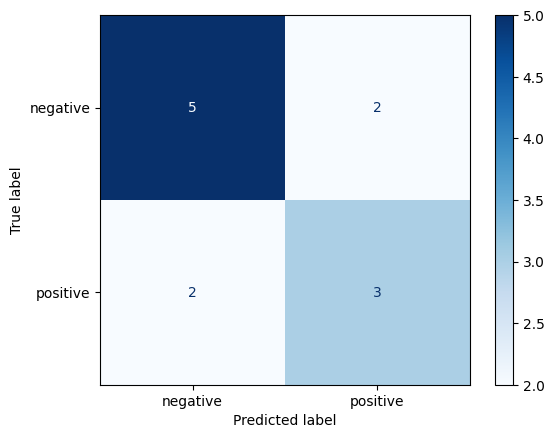

In [93]:
# Confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap="Blues")
plt.show()

In [94]:
# Prediction function
def predict_sentiment(input_text, trained_model, tfidf_vectorizer):
    input_vectorized = tfidf_vectorizer.transform([input_text])
    prediction = trained_model.predict(input_vectorized)
    return prediction[0]

# Test examples
test_samples = [
    "Football is fun to watch and enjoy",
    "Nepal is very good at cricket",
    "Ronaldo and Messi are good football players",
    "The unexpected resignation of the coach has left the team in disarray",
    "Sports fandom can foster a sense of community and belonging among fans"
]

for sample in test_samples:
    sentiment_prediction = predict_sentiment(sample, classifier, vectorizer)
    print(f"Test_Text: {sample}\nPredicted Sentiment: {sentiment_prediction}\n")

Test_Text: Football is fun to watch and enjoy
Predicted Sentiment: positive

Test_Text: Nepal is very good at cricket
Predicted Sentiment: positive

Test_Text: Ronaldo and Messi are good football players
Predicted Sentiment: positive

Test_Text: The unexpected resignation of the coach has left the team in disarray
Predicted Sentiment: negative

Test_Text: Sports fandom can foster a sense of community and belonging among fans
Predicted Sentiment: positive

